# PREDICCIÓN DEL CONSUMO DE ENERGÍA USANDO REDES LSTM

## 1 - ¿Qué es una serie de tiempo?

Es una secuencia de datos numéricos organizados cronológicamente. Estos datos usualmente se obtienen a intervalos regulares (cada mes, cada día, cada hora, cada segundo, etc.).

![](https://machinelearningmastery.com/wp-content/uploads/2016/11/Minimum-Daily-Temperatures.png)

(*Imagen tomada de machinelearningmastery.com*)

## 2 - El problema a resolver

Queremos desarrollar un modelo que sea capaz de aprender el patrón de comportamiento en una serie de tiempo (la demanda de Energía Eléctrica) en una región de Estados Unidos, y que posteriormente logre predecir cómo se comportará esta demanda en un futuro cercano.

![](https://drive.google.com/uc?export=view&id=1UaTeYJVVeHxA2nUX2d9tQIZJ8TiDPEAt)

## 3 - El set de datos

El dataset proviene de una empresa distribuidora de Energía Eléctrica en Estados Unidos (PJM Interconnection LLC), y contiene el comportamiento histórico de la demanda (en MegaWatts) entre los años 2004 y 2018 para la ciudad de Dayton (Ohio). Los registros se realizaron con una periodicidad de 1 hora.

In [1]:
import pandas as pd

ruta = 'DAYTON_hourly_2004_2018.csv'

# Leer el set de datos
datos = pd.read_csv(ruta, index_col=0, parse_dates=True)
datos.head()

/home/rodrigo/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


,DAYTON_MW
Datetime,
2004-12-31 01:00:00,1596.0
2004-12-31 02:00:00,1517.0
2004-12-31 03:00:00,1486.0
2004-12-31 04:00:00,1469.0
2004-12-31 05:00:00,1472.0


In [2]:
datos.shape

(121275, 1)

In [3]:
# Y organizar cronológicamente
datos.sort_index(inplace=True)

/home/rodrigo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


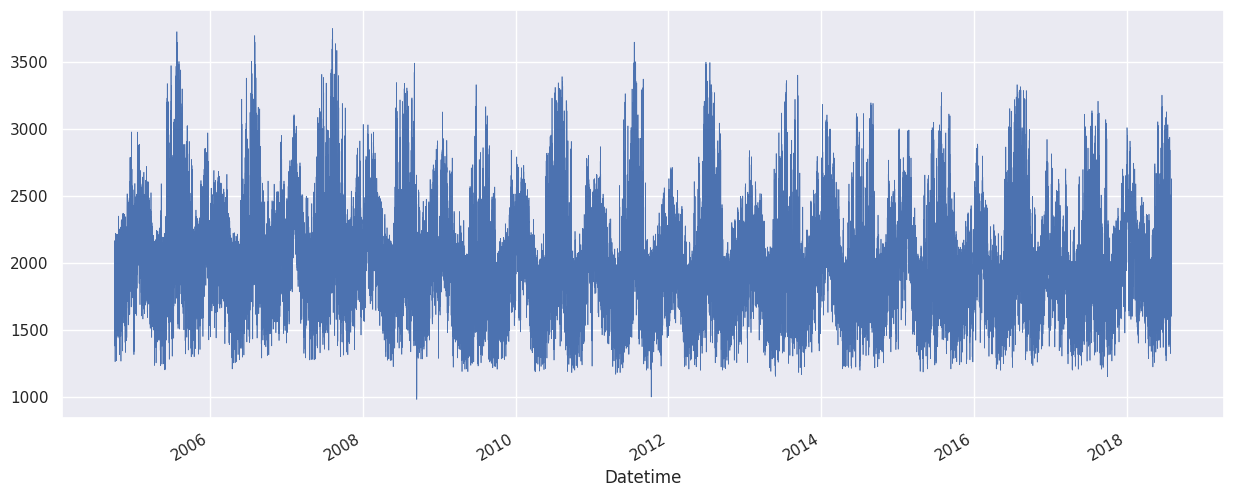

In [4]:
# Veamos cómo son los datos
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(15, 6)})
datos['DAYTON_MW'].plot(linewidth=0.5);

## 4 - Sets de entrenamiento y prueba

Como entrada al modelo usaremos bloques de 200 datos consecutivos (`X_train`) y el modelo deberá aprender a predecir el dato 201 de la secuencia (`Y_train`):

![](https://drive.google.com/uc?export=view&id=1_VqvozHTfjVrzzJzBAII3pIendriES40)

In [5]:
import numpy as np

DATOS = datos['DAYTON_MW'].values

# Primero dividamos los sets entre train y test
# En este caso la partición no puede ser aleatoria
# (se debe preservar el orden de la secuencia)
TRAIN_SIZE = 0.9
idx = round(len(DATOS)*TRAIN_SIZE)
datos_train = DATOS[0:idx]
datos_test = DATOS[idx:]

In [6]:
datos_train.reshape(-1,1).shape

(109148, 1)

In [7]:
# Y ahora escalemos los datos entre -1 y 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
datos_train_s = scaler.fit_transform(datos_train.reshape(-1,1))
datos_test_s = scaler.transform(datos_test.reshape(-1,1))

In [8]:
# Sets de entrenamiento y prueba
LONG_SEC = 360

X_train, Y_train = [], []
for i in range(len(datos_train_s)-LONG_SEC):
  X_train.append(datos_train_s[i:i+LONG_SEC])
  Y_train.append(datos_train_s[i+LONG_SEC])

X_test, Y_test = [], []
for i in range(len(datos_test_s)-LONG_SEC):
  X_test.append(datos_test_s[i:i+LONG_SEC])
  Y_test.append(datos_test_s[i+LONG_SEC])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(108788, 360, 1) (108788, 1)
(11767, 360, 1) (11767, 1)


In [10]:
# Un ejemplo de entrenamiento:

ID = 623
print(f'Ejemplo {ID}:')
print(f'   Entrada: {X_train[ID,:,:].T}')
print(f'   Salida: {Y_train[ID]}')

Ejemplo 623:
   Entrada: [[-4.26917511e-01 -5.18813314e-01 -5.83212735e-01 -5.98408104e-01
  -6.09985528e-01 -5.83936324e-01 -4.93487699e-01 -3.03183792e-01
  -1.54848046e-01 -1.30969609e-01 -1.27351664e-01 -1.13603473e-01
  -1.22286541e-01 -1.25904486e-01 -1.26628075e-01 -1.41099855e-01
  -1.64254703e-01 -1.60636758e-01 -1.64978292e-01 -1.33140376e-01
  -8.53835022e-02 -1.15050651e-01 -1.75832127e-01 -2.92329957e-01
  -4.10274964e-01 -5.02170767e-01 -5.50651230e-01 -5.75976845e-01
  -5.85383502e-01 -5.61505065e-01 -4.71780029e-01 -2.80752533e-01
  -1.40376266e-01 -1.43270622e-01 -1.44717800e-01 -1.37481910e-01
  -1.50506512e-01 -1.54848046e-01 -1.51953690e-01 -1.63531114e-01
  -1.86685962e-01 -1.85962373e-01 -2.03328509e-01 -2.09117221e-01
  -1.43270622e-01 -1.48335745e-01 -1.98263386e-01 -3.08248915e-01
  -4.14616498e-01 -4.95658466e-01 -5.27496382e-01 -5.55716353e-01
  -5.73806078e-01 -5.49204052e-01 -4.65991317e-01 -2.80028944e-01
  -1.26628075e-01 -1.07814761e-01 -1.15050651e-01 -

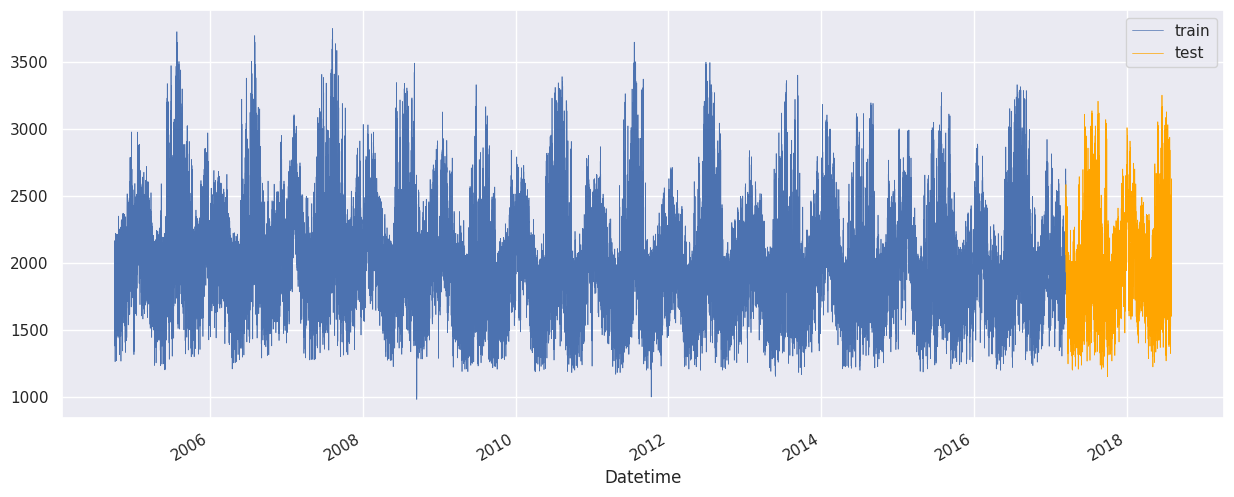

In [11]:
datos['DAYTON_MW'].iloc[0:idx].plot(linewidth=0.5, label='train')
datos['DAYTON_MW'].iloc[idx:].plot(linewidth=0.5, color='orange', label='test')
plt.legend();

## 5 - Creación y entrenamiento del modelo

In [12]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

"""# Semilla de los generadores aleatorios
SEED = 88
tf.random.set_seed(SEED)
np.random.seed(SEED)"""

# El modelo
N_UNITS = 133
modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=(LONG_SEC,1)))
modelo.add(Dense(1))

In [13]:
# Compilación y entrenamiento
optimizador = RMSprop(learning_rate=0.0009)
modelo.compile(optimizer=optimizador, loss='mse', metrics='mean_absolute_error')

# Entrenamiento
EPOCHS = 20
BATCH_SIZE = 256
modelo.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
           validation_data = (X_test, Y_test))

Epoch 1/20
425/425 [==============================] - 15s 31ms/step - loss: 0.0091 - mean_absolute_error: 0.0692 - val_loss: 0.0021 - val_mean_absolute_error: 0.0362
Epoch 2/20
425/425 [==============================] - 13s 31ms/step - loss: 0.0021 - mean_absolute_error: 0.0343 - val_loss: 0.0016 - val_mean_absolute_error: 0.0301
Epoch 3/20
425/425 [==============================] - 13s 30ms/step - loss: 0.0014 - mean_absolute_error: 0.0279 - val_loss: 0.0010 - val_mean_absolute_error: 0.0238
Epoch 4/20
425/425 [==============================] - 13s 31ms/step - loss: 0.0012 - mean_absolute_error: 0.0259 - val_loss: 9.8132e-04 - val_mean_absolute_error: 0.0229
Epoch 5/20
425/425 [==============================] - 13s 30ms/step - loss: 0.0012 - mean_absolute_error: 0.0250 - val_loss: 9.3055e-04 - val_mean_absolute_error: 0.0224
Epoch 6/20
425/425 [==============================] - 13s 31ms/step - loss: 0.0011 - mean_absolute_error: 0.0244 - val_loss: 8.8417e-04 - val_mean_absolute_error:

## 6 - Predicción

Verifiquemos inicialmente qué tan bien se genera la predicción sobre cada dato de prueba en `X_test`:

In [14]:
# Predicción (1 muestra, single-step)
y_pred = [y[0] for y in modelo.predict(X_test)]
y_pred = np.array(y_pred)

368/368 [==============================] - 2s 5ms/step


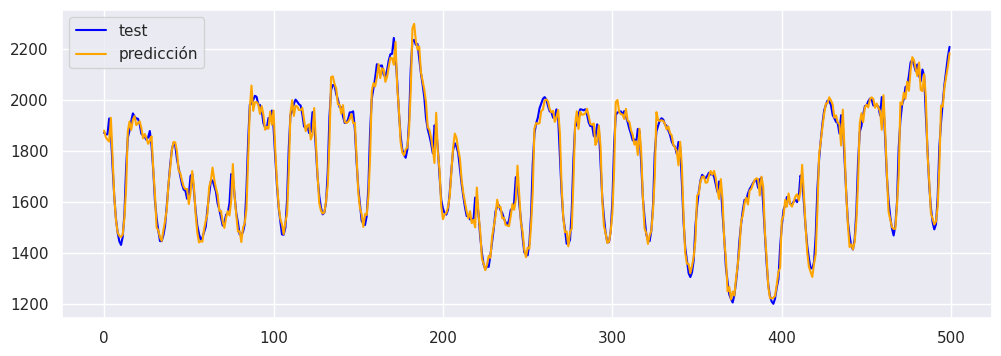

In [15]:
# Predicciones en la escala original
y_test_inv = scaler.inverse_transform(Y_test)

y_pred_inv = y_pred.reshape(-1,1)
y_pred_inv = scaler.inverse_transform(y_pred_inv)

plt.figure(figsize=(12,4))
plt.plot(y_test_inv[0:500],color='blue',label='test')
plt.plot(y_pred_inv[0:500],color='orange',label='predicción')
plt.legend();

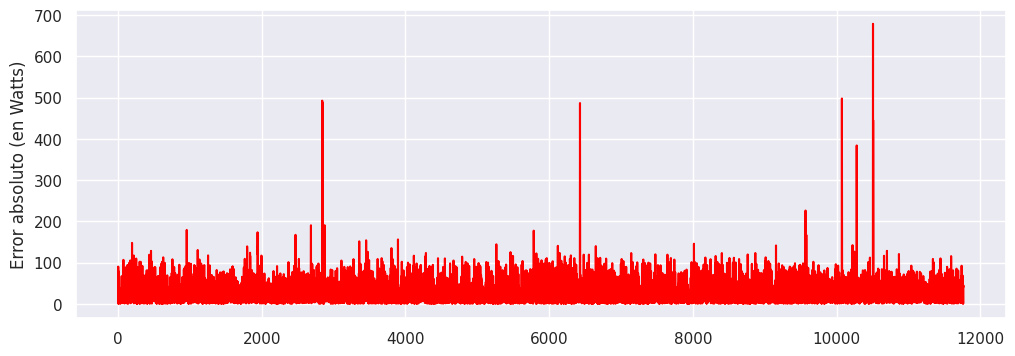

In [16]:
# Dibujar el error absoluto
plt.figure(figsize=(12,4))
plt.plot(np.abs(y_test_inv-y_pred_inv), color='red');
plt.ylabel('Error absoluto (en Watts)');

Ahora haremos predicción *multi-step*: en lugar de predecir un sólo dato vamos a predecir una secuencia completa:

In [17]:
# Tomar la primera parte de X_test como punto de inicio
x_pred = X_test[0,:,:].reshape(1,LONG_SEC,1)

# Iterativamente predecir y201 = pred(x1,x2,...,x200),
# y202 = pred(x2, x3, x4,..., x200, y201), etc...

N_preds = 4000
y_preds = []    # Las predicciones

for i in range(N_preds):
  # Predicción
  pred = modelo.predict(x_pred)
  y_preds.append(pred[0])

  # Agregar la predicción como último valor del vector de entrada
  x_pred = np.append(x_pred,pred[0])

  # Y omitir el primer valor
  x_pred = np.delete(x_pred,0)

  # Y reshape
  x_pred = np.reshape(x_pred,(1,LONG_SEC,1))

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 19ms/step


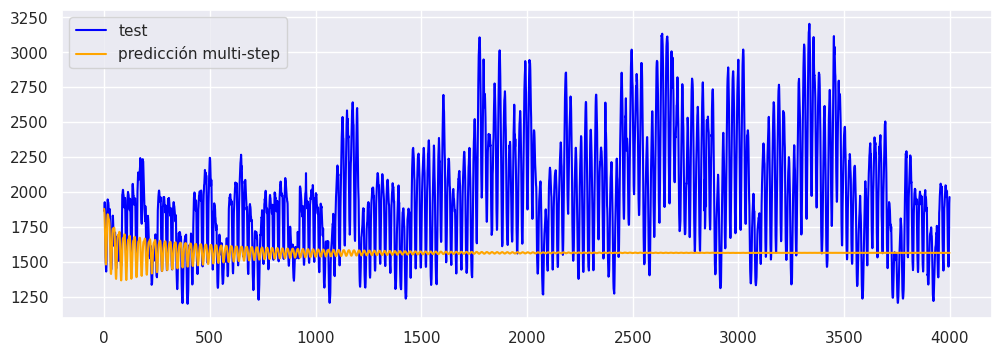

In [18]:
# Las predicciones en la escala original
y_preds = np.array(y_preds).reshape(-1,1)
y_preds = scaler.inverse_transform(y_preds)

# Comparación gráfica con el set de prueba original
plt.figure(figsize=(12,4))
plt.plot(y_test_inv[0:N_preds],color='blue',label='test')
plt.plot(y_preds[0:N_preds],color='orange',label='predicción multi-step')
plt.legend();

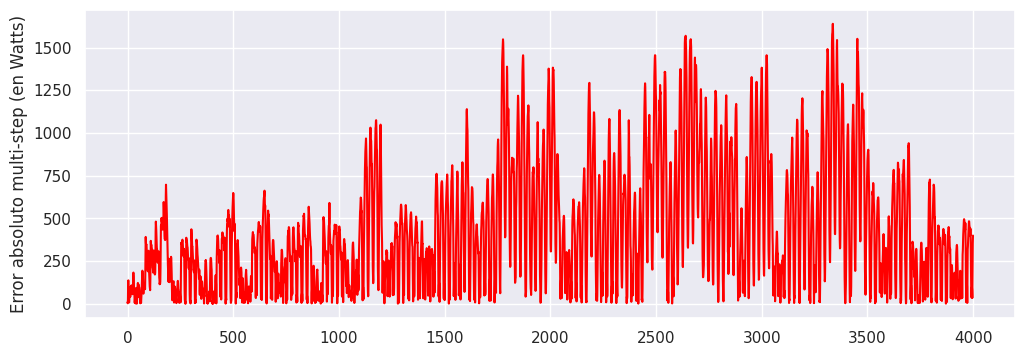

In [19]:
# Veamos el error absoluto en estas predicciones

plt.figure(figsize=(12,4))
plt.plot(np.abs(y_test_inv[0:N_preds]-y_preds[0:N_preds]), color='red')
plt.ylabel('Error absoluto multi-step (en Watts)');

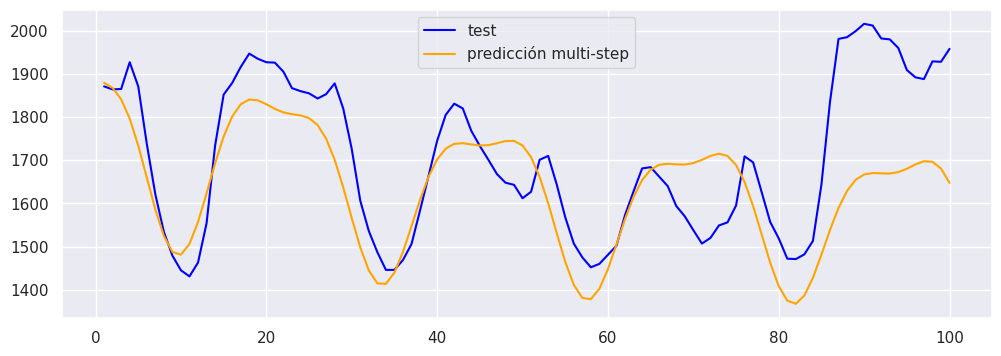

In [20]:
# Vemos que las predicciones son muy buenas para aproximadamente las
# primeras 20 horas. Después de esto los errores en la predicción
# son acumulativos y la predicción empeora

HRS = 100
plt.figure(figsize=(12,4))
plt.plot(range(1,HRS+1),y_test_inv[0:HRS],color='blue',label='test')
plt.plot(range(1,HRS+1),y_preds[0:HRS],color='orange',label='predicción multi-step')
plt.legend();